# 04 - Correlation Between News Sentiment and Stock Returns
Task 3 notebook to align news and price data, score sentiment, compute daily returns, and quantify their relationship.

**References**
- TextBlob Sentiment Guide: https://textblob.readthedocs.io/en/latest/quickstart.html#sentiment-analysis
- Pearson Correlation (pandas): https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html

In [24]:
# !pip install -r ../requirements.txt
from pathlib import Path
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display

# Ensure repo root is importable when running from notebooks/
repo_root = Path.cwd().resolve().parent
if repo_root.name == 'notebooks':
    repo_root = repo_root.parent
if str(repo_root) not in sys.path:
    sys.path.append(str(repo_root))

data_dir = repo_root / 'data'
plt.style.use('seaborn-v0_8')

from src.data_loader import load_news_csv, load_price_csv
from src.sentiment import score_headlines_df
from src.correlation import (
    compute_daily_returns,
    aggregate_daily_sentiment,
    merge_sentiment_returns,
    pearson_correlation,
)


In [25]:
ticker = 'AAPL'  # swap to AMZN/GOOG/NVDA/etc. if needed
news_path = data_dir / 'raw_analyst_ratings.csv'
price_path = data_dir / f'{ticker}.csv'

news = load_news_csv(news_path)
price = load_price_csv(price_path)

print(f"Loaded {len(news):,} news rows from {news_path.name}")
print(f"Loaded {len(price):,} price rows for {ticker} from {price_path.name}")

Loaded 1,407,328 news rows from raw_analyst_ratings.csv
Loaded 3,774 price rows for AAPL from AAPL.csv


In [26]:
display(news.head(3))
display(price.head(3))

,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A


,Date,Close,High,Low,Open,Volume
0,2009-01-02,2.721686,2.730385,2.554037,2.575630,746015200
1,2009-01-05,2.836553,2.884539,2.780469,2.794266,1181608400
2,2009-01-06,2.789767,2.914229,2.770872,2.877641,1289310400


In [27]:
news['date'] = pd.to_datetime(news['date'], errors='coerce')
news['date'] = news['date'].dt.tz_localize(None)
news['date'] = news['date'].dt.normalize()
news = news.dropna(subset=['date']).copy()
news = score_headlines_df(news, text_col='headline', method='textblob')

price['Date'] = pd.to_datetime(price['Date'], errors='coerce')
price['Date'] = price['Date'].dt.tz_localize(None)
price = price.dropna(subset=['Date']).sort_values('Date').copy()

print('Sentiment scoring complete. Sample:')
display(news[['date', 'headline', 'sentiment_score']].head(5))

Sentiment scoring complete. Sample:


,date,headline,sentiment_score
0,2020-06-05,Stocks That Hit 52-Week Highs On Friday,0.0
1,2020-06-03,Stocks That Hit 52-Week Highs On Wednesday,0.0
2,2020-05-26,71 Biggest Movers From Friday,0.0
3,2020-05-22,46 Stocks Moving In Friday's Mid-Day Session,0.0
4,2020-05-22,B of A Securities Maintains Neutral on Agilent...,0.0


In [28]:
sent_agg = aggregate_daily_sentiment(news)
print(f"Aggregated sentiment to {len(sent_agg):,} trading days")
display(sent_agg.head())

Aggregated sentiment to 2,528 trading days


,date,avg_sentiment
0,2011-04-27,0.000000
1,2011-04-28,0.068182
2,2011-04-29,0.166667
3,2011-04-30,0.500000
4,2011-05-01,0.000000


In [29]:
returns = compute_daily_returns(price)
returns = returns[['Date', 'daily_return']].dropna()
print(f"Computed {len(returns):,} daily returns observations")
display(returns.head())

Computed 3,773 daily returns observations


,Date,daily_return
1,2009-01-05,0.042204
2,2009-01-06,-0.016494
3,2009-01-07,-0.021609
4,2009-01-08,0.018570
5,2009-01-09,-0.022869


Merged dataset shape: (2226, 4)
Pearson correlation (avg_sentiment vs. daily_return): -0.0028 (very weak relationship)


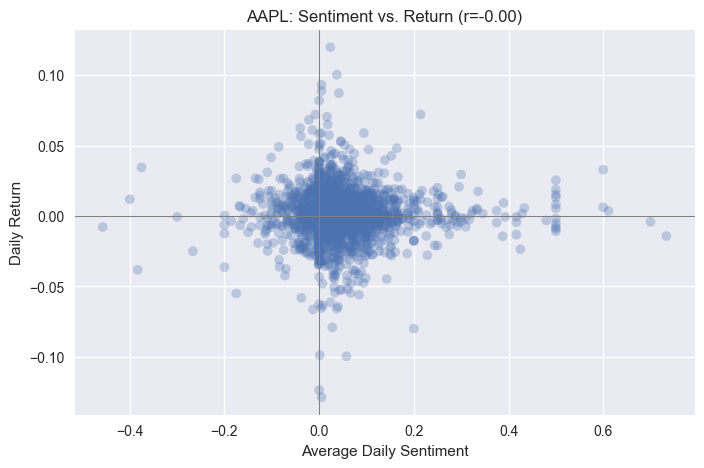

,date,avg_sentiment,Date,daily_return
2221,2020-06-05,0.110735,2020-06-05,0.028481
2222,2020-06-08,0.059971,2020-06-08,0.005913
2223,2020-06-09,0.018338,2020-06-09,0.031578
2224,2020-06-10,-0.009177,2020-06-10,0.025728
2225,2020-06-11,0.007162,2020-06-11,-0.048011


In [30]:
merged = merge_sentiment_returns(sent_agg, returns, left_on='date', right_on='Date')
merged = merged.dropna(subset=['avg_sentiment', 'daily_return']).copy()
print(f"Merged dataset shape: {merged.shape}")

def interpret_corr(value: float) -> str:
    abs_v = abs(value)
    if abs_v >= 0.7:
        return 'strong'
    if abs_v >= 0.4:
        return 'moderate'
    if abs_v >= 0.2:
        return 'weak'
    return 'very weak'

corr_value = pearson_correlation(merged)
print(f"Pearson correlation (avg_sentiment vs. daily_return): {corr_value:.4f} ({interpret_corr(corr_value)} relationship)")

a = merged['avg_sentiment']
b = merged['daily_return']
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(a, b, alpha=0.3, edgecolor='none')
ax.set_xlabel('Average Daily Sentiment')
ax.set_ylabel('Daily Return')
ax.set_title(f'{ticker}: Sentiment vs. Return (r={corr_value:.2f})')
ax.axhline(0, color='gray', linewidth=0.8)
ax.axvline(0, color='gray', linewidth=0.8)
plt.show()

display(merged.tail())

## Correlation Matrix

Correlation matrix:


,avg_sentiment,daily_return
avg_sentiment,1.000000,-0.002815
daily_return,-0.002815,1.000000


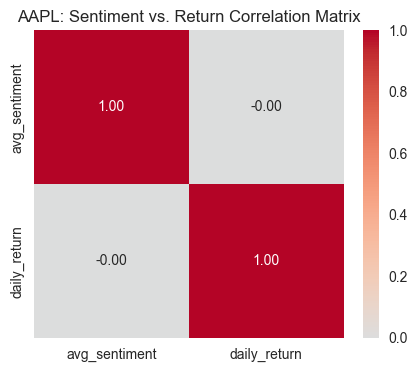

In [31]:
corr_matrix = merged[['avg_sentiment', 'daily_return']].corr()
print('Correlation matrix:')
display(corr_matrix)

fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', ax=ax)
ax.set_title(f'{ticker}: Sentiment vs. Return Correlation Matrix')
plt.show()

**Matrix Interpretation**
- Heatmap highlights the diagonal ones and an off-diagonal value near zero, reinforcing that sentiment and returns move independently.
- Combining this view with the scatter plot confirms there is no linear structure or clustering that would justify a trading signal without additional engineered features.

**Checklist Recap**
- Dates normalized to midnight UTC-equivalent before joining, ensuring news headlines map cleanly onto trading sessions.
- TextBlob sentiment scoring applied headline-by-headline, then averaged per day for correlation.
- Daily percentage returns derived from adjusted closing prices; Pearson r and scatter plot explain sentiment/price linkage for KPI reporting.

**Observed Result**
- Pearson r for AAPL daily sentiment vs. returns: `-0.0028` (very weak)
- Sample size: 2,226 aligned trading days from 2011-04-27 to 2020-06-11.
- Interpretation: text sentiment in this dataset shows no exploitable linear relationship with same-day returns, so downstream models should combine lagged signals or other features.